In [1]:
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [2]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [3]:
w_r = w[::-1]
print(w_r)

[3 5 1 2]


In [4]:
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [5]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [6]:
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [7]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [8]:
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [9]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])
w = np.array([[2, 0],[0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [10]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [11]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

In [12]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

In [13]:
c_out.numpy( ).reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [14]:
x = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13, 14, 15, 16]])
x = x.reshape(1, 4, 4, 1)

In [15]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy( ).reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

In [16]:
class ConvolutionNetwork:
    
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
        self.n_kernels = n_kernels  #합성곱의 커널 개수
        self.kernel_size = 3        #커널크기
        self.optimizer = None       #옵티마이저
        self.conv_w = None          #합성곱층의 가중치
        self.conv_b = None          #합성곱층의 절편
        self.units = units          #은닉층의 뉴런개수
        self.batch_size = batch_size #배치 크기
        self.w1 = None             #은닉층의 가중치
        self.b1 = None              #은닉층의절편
        self.w2 = None              #출력층의 가중치
        self.b2 = None              #출력층의 절편
        self.a1 = None              #은닉층의 활성화 출력
        self.losses = []              #훈련 손실
        self.val_losses= []              #검증 손실
        self.lr = learning_rate              #학습률
        
    def forpass(self, x):
        # 3 x 3 합성곱 연산 수행
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        #렐루 활성화 함수 적용
        r_out = tf.nn.relu(c_out)
        # 2 x 2 최대 풀링을 적용
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        # 첫 번째 ㅅ배치 차원을 제외하고 출력을 일렬로 펼칩니다.
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1  #첫번째 층의 선형식을 계산
        a1 = tf.nn.relu(z1)                     #활성화 함수 적용
        z2 = tf.matmul(a1, self.w2) + self.b2    #두번째 층의 선형식 계산
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
        n_features = 14 * 14 * self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))    #(특성 개수, 은닉층의 크기)
        self.b1 = tf.Variable(np.zeros(self.units), dtype=float)  #은닉층의크기
        self.w2 = tf.Variable(g((self.units, n_classes)))    #(특성 개수, 은닉층의 크기)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)  #은닉층의크기
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])       #은닉층과 출력층의 가중치를 초기화 합니다.
        self.optimizer = tf.optimizers.SGD(learning_rate = self.lr)
        #epochs만큼 반복
        for i in range(epochs):
            print('에포크',i, end=' ')
            #제너레이터 함수에서 반환한 미니 배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x,y):
                print('.', end=' ')
                self.training(x_batch, y_batch)
                #배치 손실 기록
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            #배치손실 평균을 내어 훈련 손실값으로 저장
            self.losses.append(np.mean(batch_losses))
            #검증 세트에 대한 손실 계산
            self.val_losses.append(self.get_loss(x_val, y_val))
    
    #미니 배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size    #미니 배치 횟수
        indexes = np.random.permutation(np.arange(len(x)))  #인덱스를 섞는다
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i +1)
            yield x[start:end], y[start:end]  #batch_size 만큼 슬라이싱 하여 반환
            
    def training(self, x, y):
        m = len(x)            #샘플 개수 저장
        with tf.GradientTape( ) as tape:
            z = self.forpass(x)     #정방향 계산 수행
            #손실 계산
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)
            
        weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
        #가중치에 대한 그레이디언트 계산
        grads = tape.gradient(loss, weights_list)
        #가중치 업데이트
        self.optimizer.apply_gradients(zip(grads, weights_list))
        
    def predict(self, x):
        z = self.forpass(x)       #정방향 계산 수행
        return np.argmax(z.numpy( ), axis = 1)  #가장 큰값의 인덱스를 반환
    
    def score(self, x, y):
        #예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
        return np.mean(self.predict(x) == np.argmax(y, axis=1))
    
    def get_loss(self, x, y):
        z = self.forpass(x)          #정방향 계산 수행
        #손실을 계산하여 저장
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()
        

In [17]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [19]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [20]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [21]:
x_train.shape

(48000, 28, 28, 1)

In [22]:
x_train = x_train / 255
x_val = x_val /255

In [23]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val= x_val, y_val=y_val_encoded, epochs=20)

에포크 0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
에포크 1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

에포크 10 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
에포크 11 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

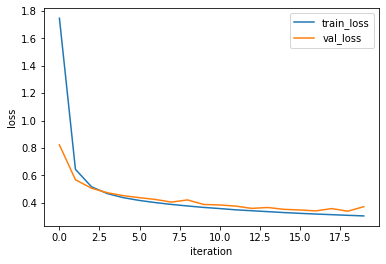

In [24]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [25]:
cn.score(x_val, y_val_encoded)

0.8683333333333333

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [27]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10,(3,3), activation='relu', padding='same', input_shape=(28,28,1)))

In [28]:
conv1.add(MaxPooling2D(2, 2))

In [29]:
conv1.add(Flatten())

In [30]:
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [31]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [32]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4435 - accuracy: 0.8430 - val_loss: 0.3440 - val_accuracy: 0.8744
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3033 - accuracy: 0.8907 - val_loss: 0.3284 - val_accuracy: 0.8776
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2611 - accuracy: 0.9030 - val_loss: 0.2965 - val_accuracy: 0.8964
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2309 - accuracy: 0.9142 - val_loss: 0.2611 - val_accuracy: 0.9072
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2051 - accuracy: 0.9235 - val_loss: 0.2433 - val_accuracy: 0.9141
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1850 - accuracy: 0.9304 - val_loss: 0.2982 - val_accuracy: 0.8957
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1678 - accuracy: 0.9369 - val_loss: 0.2421 - val_accuracy:

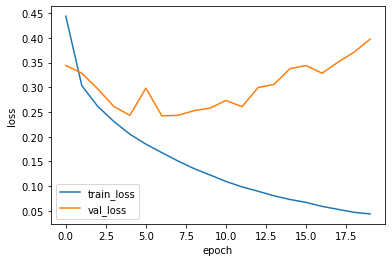

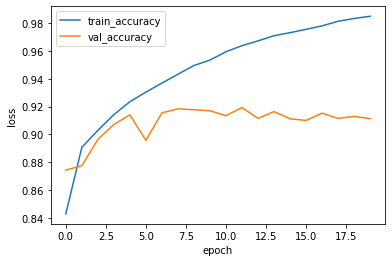

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()



# 드롭아웃 적용해 합성곱 신경망 구현하기

In [35]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))

In [36]:
conv2.add(Flatten())
conv2.add(Dropout(0.3))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [37]:
conv2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [38]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val,y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4738 - accuracy: 0.8288 - val_loss: 0.3274 - val_accuracy: 0.8815
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3384 - accuracy: 0.8755 - val_loss: 0.2935 - val_accuracy: 0.8946
Epoch 3/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2998 - accuracy: 0.8886 - val_loss: 0.2712 - val_accuracy: 0.9032
Epoch 4/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2728 - accuracy: 0.8996 - val_loss: 0.2676 - val_accuracy: 0.8983
Epoch 5/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2530 - accuracy: 0.9054 - val_loss: 0.2509 - val_accuracy: 0.9077
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2369 - accuracy: 0.9114 - val_loss: 0.2371 - val_accuracy: 0.9135
Epoch 7/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2196 - accuracy: 0.9184 - val_loss: 0.2331 - val_accuracy:

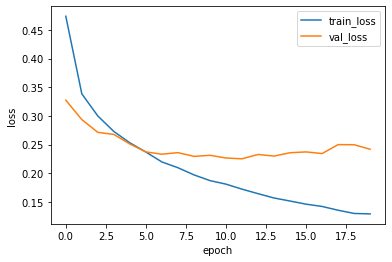

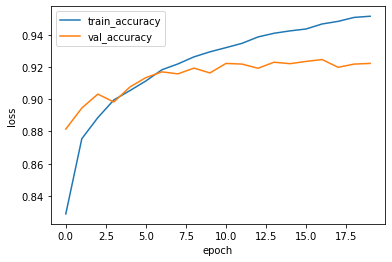

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()